### MTH9897 HW1

Jiang, Yumin \
Lin, Krystal \
Zhu, Yiqing 

# Introduction

### `SpreadCurve` Class Overview

The `SpreadCurve` class is designed for visualizing and modeling bond spreads (T Spreads). The class facilitates loading, cleaning, and transforming bond data from WRDS for specified tickers and runs regression models to fit a curve to the bond's spread data. 

Key features of the `SpreadCurve` class:
- **Data**: It loads bond data, processes it by calculating relevant features (such as bond age, fraction outstanding, dirty price), and filters the data for consistency.For the exercise, we exclude bonds with tmt < 0.5 as short maturity bond have liquidity.
- **Visualization**: The class provides functions to generate plots of T Spread and the actual and fitted T Spread curves.
- **Curve Fitting**: It fits a WLS regression model:
$$
t\_spread = a + b \cdot \log(1 + tmt) + c \cdot \log(tmt) + d \cdot coupon
$$

In [1]:
from t_spread_curve import SpreadCurve
from strategy_backtest import Strategy

In [2]:
tickers = ['AAPL', 'AMZN', 'IBM', 'MSFT', 'WMT']
x_var = 'tmt'
# t_spread ~ a + b*log(1 + tmt) + c*log(tmt) + d*coupon
features = [f'log_{x_var}', x_var, 'coupon']
spread_curve = SpreadCurve(tickers, features, 't_spread',x_var)

These charts show the relationship between **T Spread** (in basis points) and **Duration** (in years) for bonds issued by five companies (AAPL, AMZN, IBM, MSFT, WMT). The size of the circles represents the **amount outstanding** of each bond, indicating the scale of the bond issue.

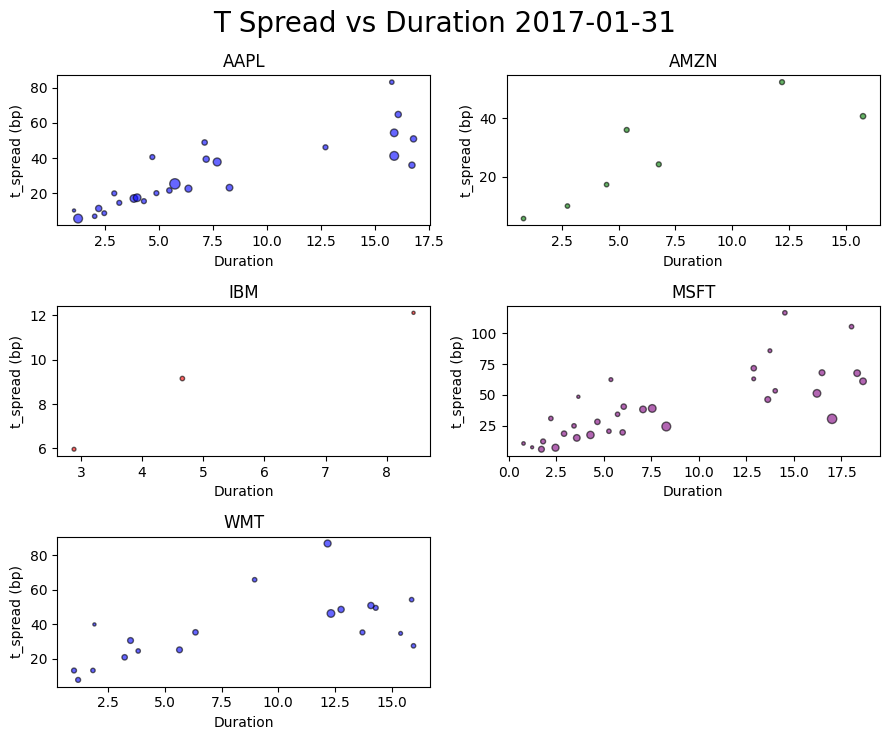

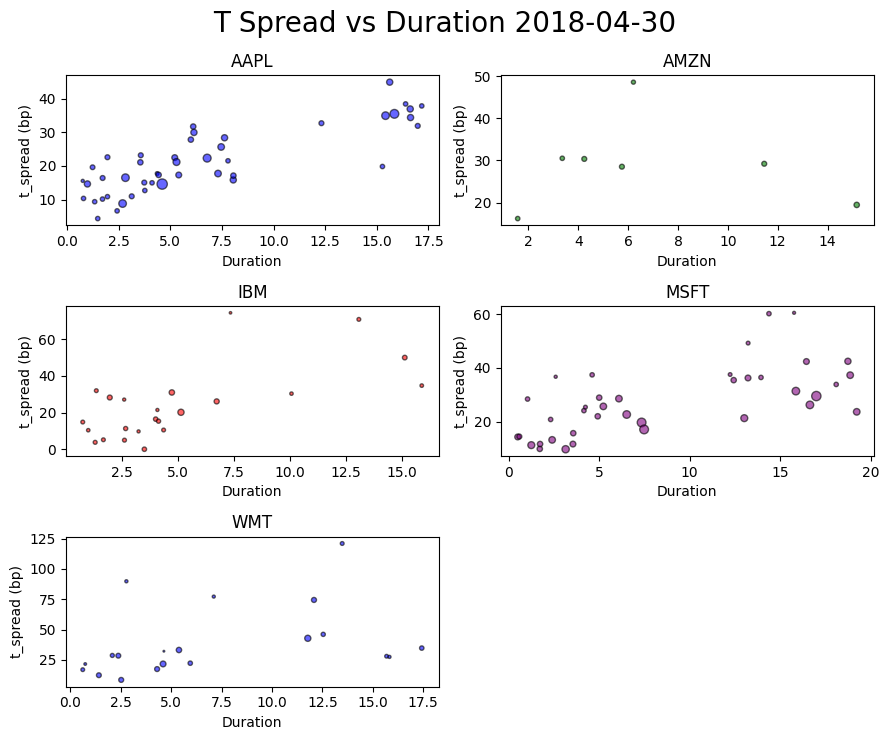

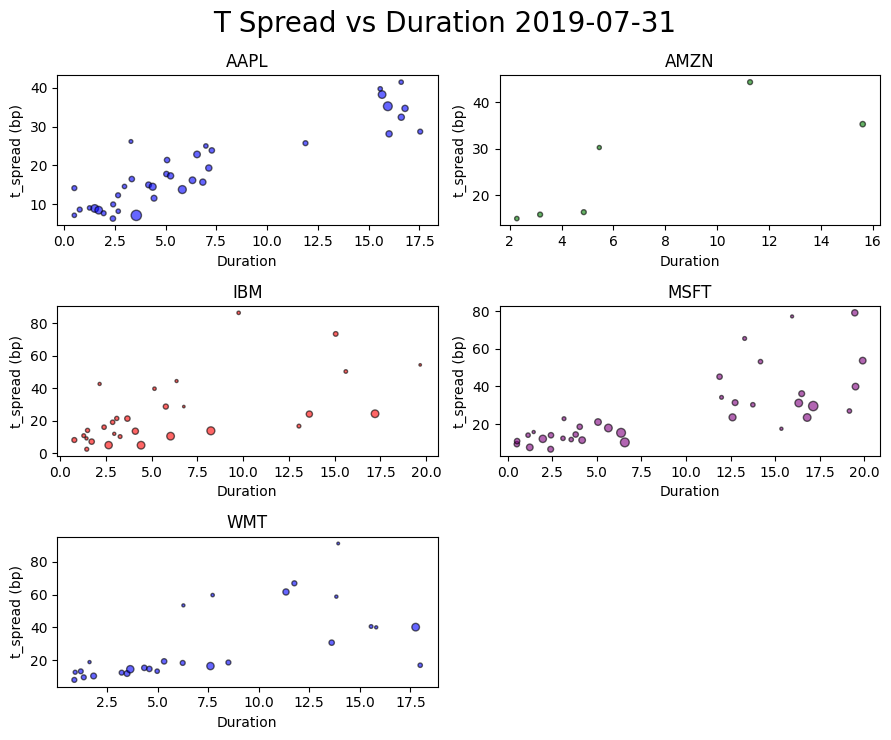

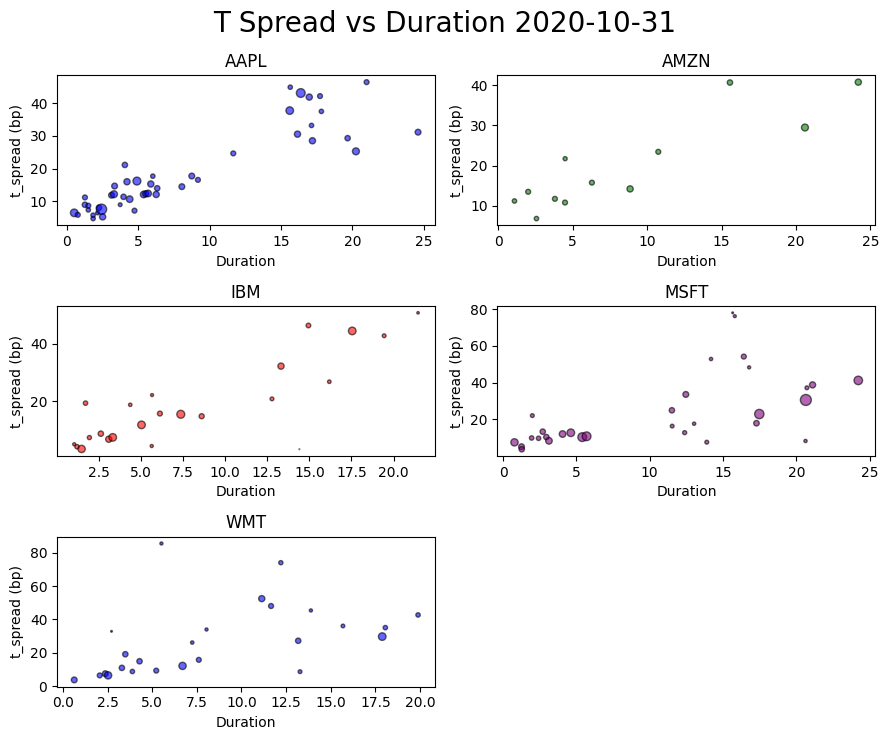

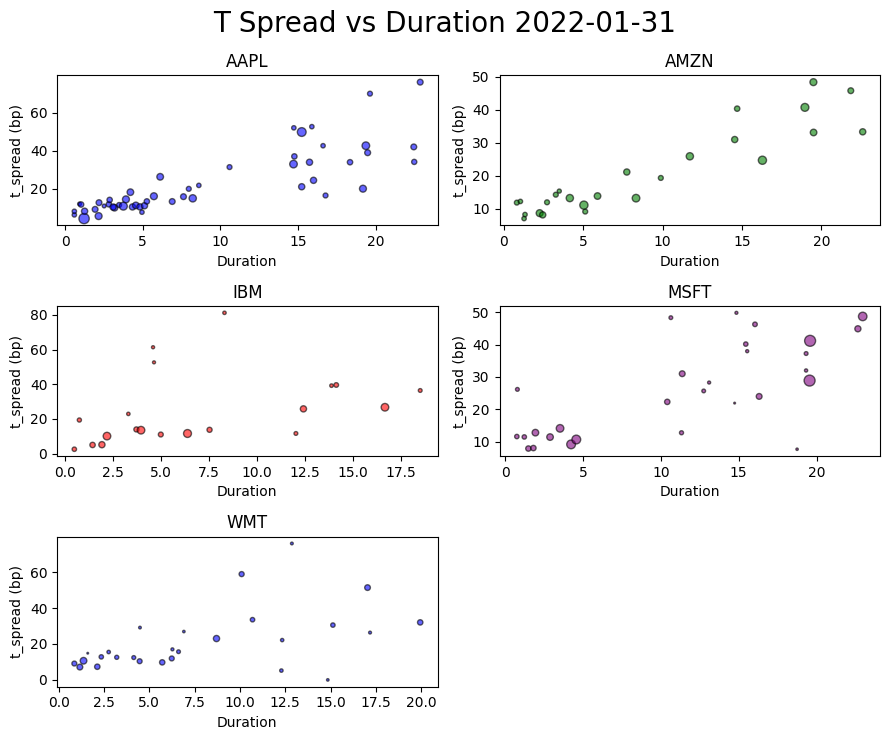

In [3]:
#plot the T-spread vs Duration on selected dates
random_dates = spread_curve.bond_data.date.unique()[::15]

for d in random_dates:
    spread_curve.t_spread_plots(d)

# Curve Fitting
We fit a WLS regression model:

$$
t\_spread = a + b \cdot \log(1 + tmt) + c \cdot \log(tmt) + d \cdot coupon

$$
Before we perform regression, we handle the case of `pillar collision`, situation where two or more "pillar points" are very close to each other in maturity space. We first assign each data point to its nearst maturity bracket (in 0.5 years increment). For each maturity bracket, when there is duplicated points, we keep the data point with the highest amount outstanding. We use `amount_outstanding` as the weights of the WLS as well since this varaible can provide proxy the liquidity of the bonds and therefore the 'trustworthiness' of particular data point. 


In [4]:
spread_curve.fit(weight_col='amount_outstanding')

From the plots below, we observe that the fitted T Spread curves for different companies (AAPL, AMZN, IBM, MSFT, WMT) are not very smooth in the maturity (TMT) space. This lack of smoothness is primarily due to the fact that bonds with different coupons are present across the time to maturity spectrum.  Bonds with higher or lower coupons tend to have different risk premiums, which manifest in the observed spread.

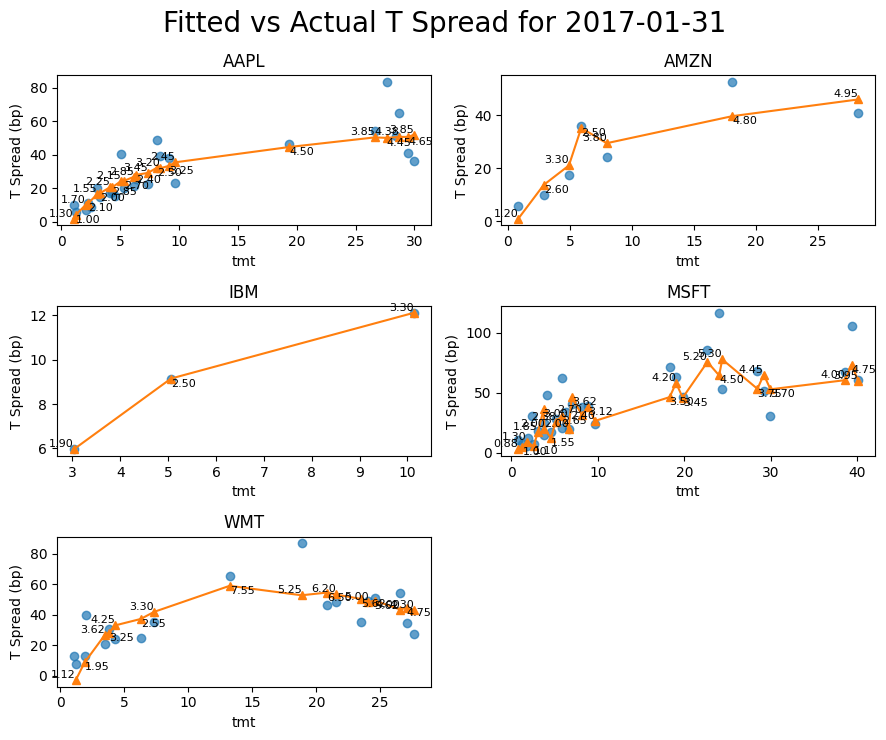

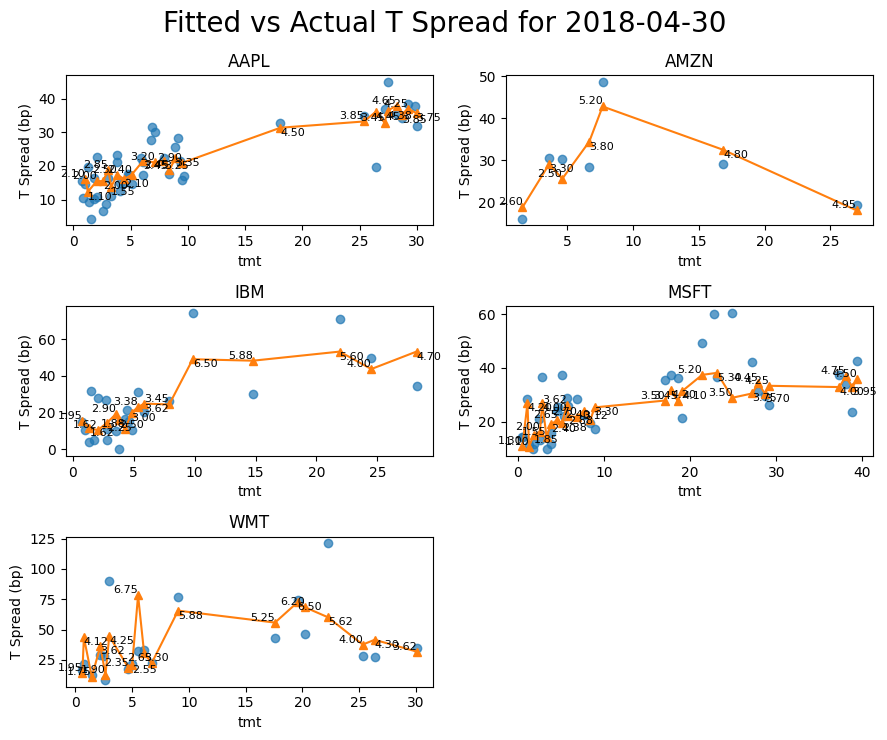

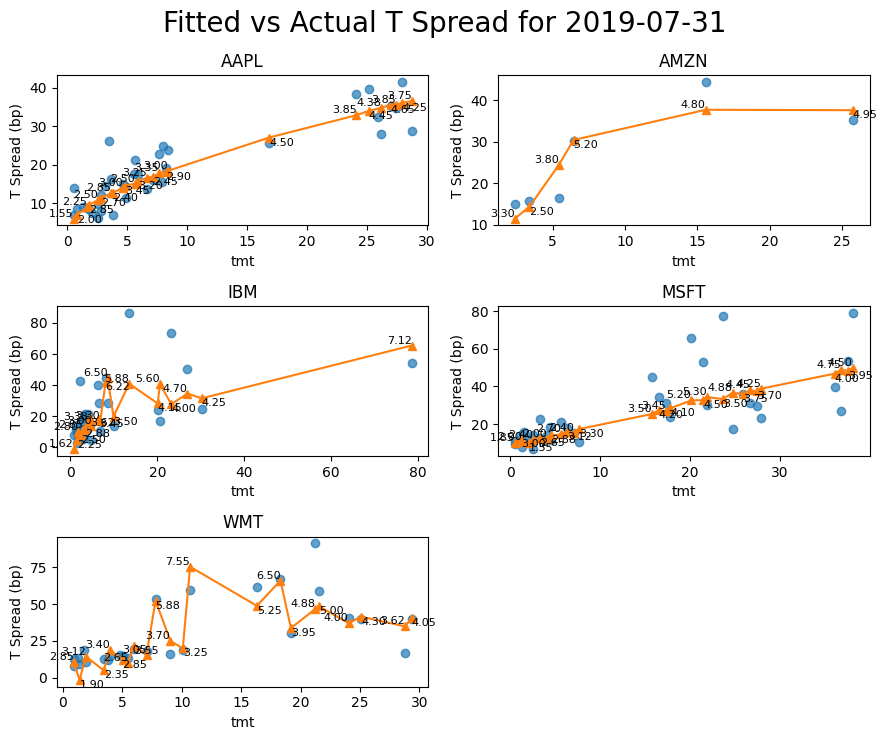

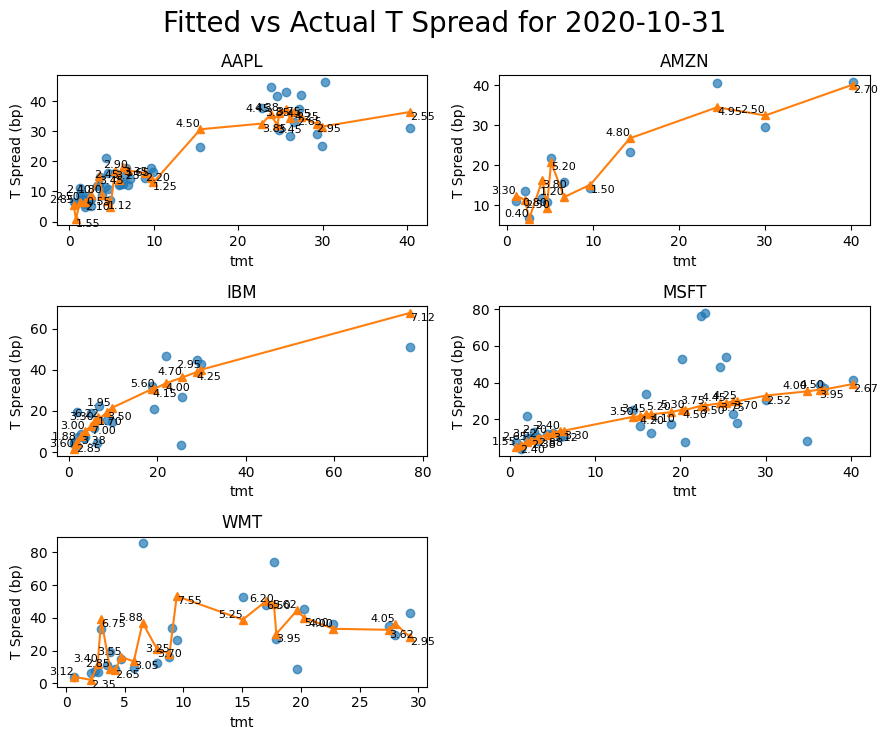

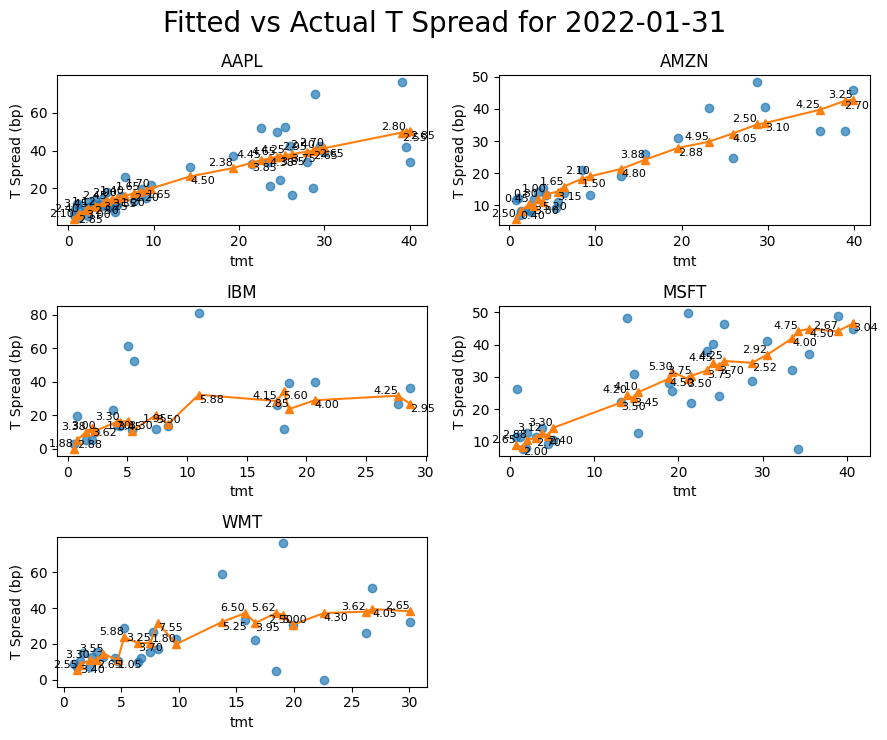

In [5]:
#plot actual vs fitted curves for random dates
for d in random_dates:
    spread_curve.plot_fitted_vs_actual(d)

# Strategy Backtest

In this section, we implement a duration-neutral long/short strategy for corporate bonds. The strategy identifies bonds as "rich" or "cheap" based on the residual of their treasury spread (`t_spread_resid = t_spread- t_spread_fitted`). Bonds classified as "cheap" have positive residuals, meaning they are priced lower than expected relative to the model, while "rich" bonds have negative residuals, meaning they are priced higher than expected.

The strategy builds a portfolio by going long on "cheap" bonds and short on "rich" bonds, aiming for a monthly rebalancing to maintain a duration-neutral portfolio. By balancing the long and short positions based on duration, the strategy aims to isolate returns driven by mispricing rather than differences in interest rate sensitivity.

### Strategy Overview:
- **Percentile-based selection**: The strategy selects the top and bottom `n` percentile of bonds based on the residual spread. Bonds in the top percentile are considered "cheap," and those in the bottom percentile are considered "rich."
- **Duration neutrality**: The strategy ensures that the weighted duration of the long (cheap) and short (rich) positions is neutral, meaning that the portfolio’s sensitivity to interest rate changes is minimized.
- **Weighting methods**: Bonds can be weighted equally, based on their residual spreads, or grouped by duration buckets to ensure a diversified exposure across different maturities. The duration based approach groups bonds into different **duration buckets** ([1,  5, 10, 15, 30]) and assigns weights within each bucket. This ensures that the portfolio is diversified across bonds with different maturities. Bonds within each duration bucket is weighted equally.
- **Monthly rebalancing**: The portfolio is rebalanced monthly, adjusting the weights of bonds to maintain the desired long/short exposures and duration neutrality.

### Performance Metrics:
After running the strategy, the class calculates key performance metrics for each company, including:
- **Annualized return**: The monthly return is calculated based on `dirty price = clean price + accural`. The mean monthly return is scaled up to an annual figure.
- **Annualized volatility**: The standard deviation of monthly returns is also annualized.
- **Turnover**: This metric measures the frequency of rebalancing or changing the portfolio's positions, which can impact transaction costs. It is calculated based on the absolute change in portfolio weights from one period to the next. Since we are using bond residual spreads to rank bonds, we use **net returns** as a proxy for the portfolio's weight changes. The turnover is computed as the average absolute difference in portfolio weights across consecutive rebalancing periods.


##### Equal Weighted Portfolio

,company,annualized_return,annualized_volatility,sharpe_ratio,turnover,max_drawdown
0,AAPL,0.188543,0.133028,1.417318,0.041472,0.136451
1,AMZN,0.081715,0.190437,0.429092,0.062822,0.277993
2,IBM,0.200409,0.490173,0.408853,0.146214,1.751282
3,MSFT,-0.211563,0.367426,-0.575797,0.109094,0.786234
4,WMT,0.128688,0.590714,0.217852,0.177546,1.479405


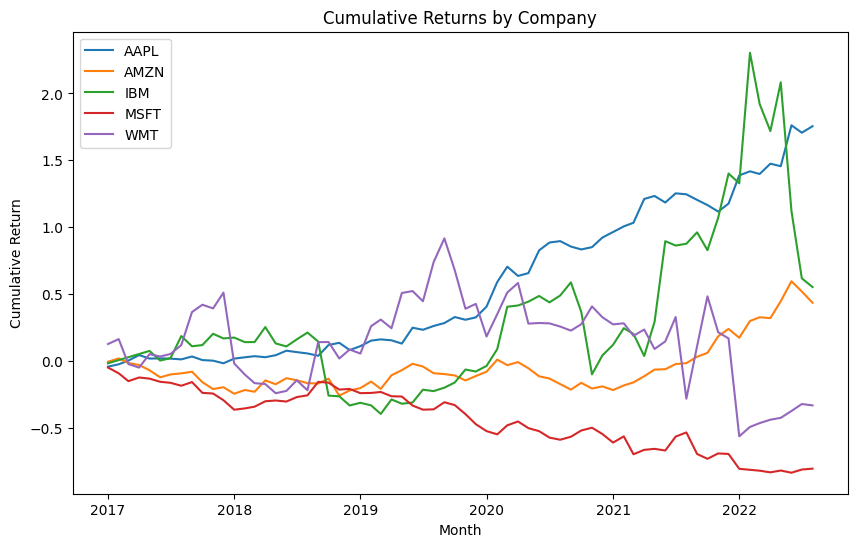

In [6]:
bond_data = spread_curve.bond_data[['date', 'isin', 'company_symbol', 'duration', 'dirty_price', 't_spread_fitted', 't_spread']].copy()
bond_data.eval('t_spread_resid = t_spread- t_spread_fitted', inplace=True)

# Instantiate the class with the bond data
strategy1 = Strategy(bond_data, 20)

# Run the strategy using equal weighting
strategy1.run_strategy(weighting='equal')

# Calculate the performance metrics
performance_metrics = strategy1.calculate_performance() 

display(performance_metrics)

# Plot cumulative returns for each company
strategy1.plot_performance() 


##### Equal Weighted Portfolio Across Duration Buckets

,company,annualized_return,annualized_volatility,sharpe_ratio,turnover,max_drawdown
0,AAPL,0.104147,0.083701,1.244275,0.027263,0.117022
1,AMZN,0.110115,0.132880,0.828680,0.037531,0.150523
2,IBM,0.117988,0.367073,0.321429,0.109473,0.498006
3,MSFT,-0.294367,0.287011,-1.025628,0.083990,0.874605
4,WMT,0.032670,0.436366,0.074869,0.132799,0.625457


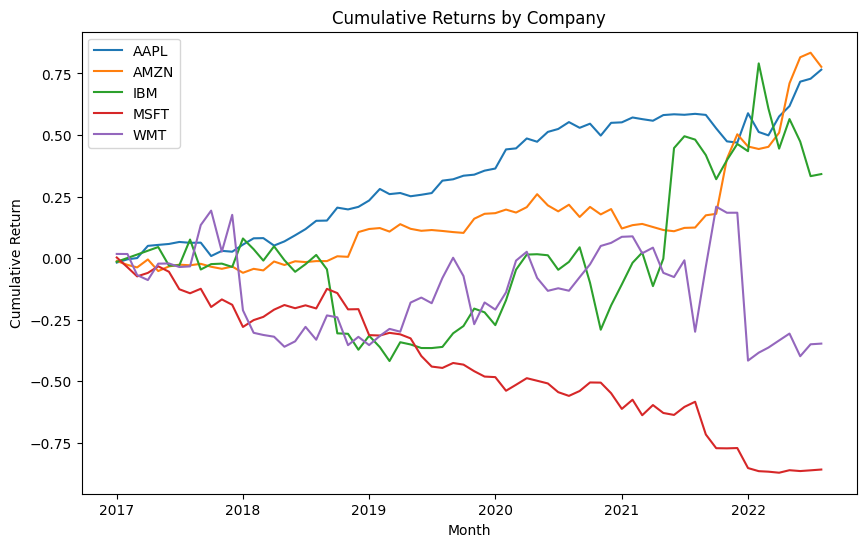

In [7]:
bond_data = spread_curve.bond_data[['date', 'isin', 'company_symbol', 'duration', 'dirty_price', 't_spread_fitted', 't_spread']].copy()
bond_data.eval('t_spread_resid = t_spread- t_spread_fitted', inplace=True)

# Instantiate the class with the bond data
strategy2 = Strategy(bond_data, 20)

strategy2.run_strategy(weighting= 'duration_based')

# Calculate the performance metrics
performance_metrics = strategy2.calculate_performance() 

display(performance_metrics)

# Plot cumulative returns for each company
strategy2.plot_performance() 


From the charts above, we can observe the performance of the strategy for different companies over time. A few notable patterns emerge: 
   - IBM experiences a **very large drawdown** starting around 2022.
   - The strategy does not seem to work well with MSFT throughout the entire period. MSFT’s cumulative returns stay relatively flat or negative, with no strong upward trends, indicating that the strategy struggled to generate positive returns for this company. This could be due to bonds with residual spreads not aligning with the strategy’s assumptions for this company.
   - While the duration-based portfolio may have a **better risk profile** as observed by the **lower drawdown**, it also results in **lower Sharpe ratios**. The smoother returns for these companies suggest that the portfolio is less volatile and better diversified across different maturities, but the lower overall returns suggest that the strategy sacrifices potential gains to maintain this lower risk.
   
In summary, while the strategy shows success with some companies (e.g., AAPL and AMZN), others (e.g., MSFT and IBM) demonstrate weaknesses in the approach. Additionally, while the duration-based portfolio offers improved risk management (lower drawdowns), it also leads to lower overall returns and Sharpe ratios, highlighting the trade-off between risk and return in this bond strategy.
